In [212]:
# common
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# thierd party

# original
from testing_framework.tests import test_algorithm
from arms.bernoulli import BernoulliArm
from algorithms.epsilon_greedy.standard import EpsilonGreedy

# set seed
SEED = 19930219
random.seed(SEED)

In [213]:
# prepare armms condition
prob_rewards = [.1, .1, .1, .1, .9]
n_arms = len(prob_rewards)
random.shuffle(prob_rewards)
ind_best_arm = np.argmax(prob_rewards)

arms = list(map(lambda prob: BernoulliArm(prob), prob_rewards))

In [214]:
## test algorithm
epsilons  = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0] # epsilon = 1.0 means AB testing
num_sims = 5000
horizon = 250

##
prob_select_best_by_epsilon = []
reward_by_epsilon = []
cum_reward_by_epsilon = []
for epsilon in epsilons:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    res = test_algorithm(algo, arms, num_sims, horizon)
    ##
    ind_selected_arm = np.array(res[2]).reshape(num_sims, -1)
    reward_at_time = np.array(res[3]).reshape(num_sims, -1)
    cum_reward_at_time = np.array(res[4]).reshape(num_sims, -1)

    prob_select_best = np.mean(ind_selected_arm == ind_best_arm, axis = 0)
    reward_at_time = np.mean(reward_at_time, axis = 0)
    cum_reward_at_time = np.mean(cum_reward_at_time, axis = 0)

    prob_select_best_by_epsilon.append(prob_select_best)
    reward_by_epsilon.append(reward_at_time)
    cum_reward_by_epsilon.append(cum_reward_at_time)

algo_name = str(type(algo)).split(".")[-1].replace("'>", "")

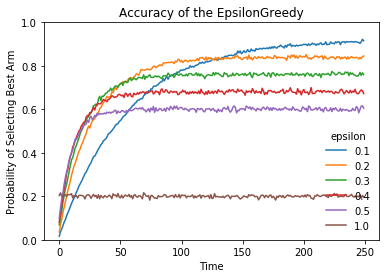

In [215]:
# ベストなアームを選ぶ確率
for i, epsilon in enumerate(epsilons):
    plt.plot(prob_select_best_by_epsilon[i], label=epsilon)

plt.title('Accuracy of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Probability of Selecting Best Arm')
plt.ylim([0., 1.])
plt.legend(title = 'epsilon', frameon = False)
plt.show()

## 示唆
### epsilonが大きいほどランダムにアームを選択するので、いいアームを見つけることが早くなる。一方で、ベストなアームを見つけた後もepsilonで探索するので、ベストなアームを選ぶ確率が頭うちとなってしまう（探索過剰）
### epsilonが小さい時は、上記の裏返し。

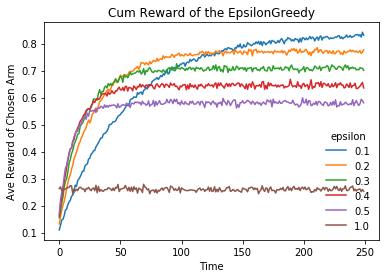

In [216]:
# 各試行において得られる報酬の推移
for i, epsilon in enumerate(epsilons):
    plt.plot(reward_by_epsilon[i], label=epsilon)

plt.title('Cum Reward of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Ave Reward of Chosen Arm')
plt.legend(title = 'epsilon', frameon = False)
plt.show()

## 示唆


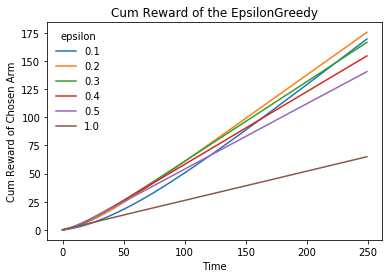

In [217]:
# 各試行において得られる累積報酬の推移
for i, epsilon in enumerate(epsilons):
    plt.plot(cum_reward_by_epsilon[i], label=epsilon)

plt.title('Cum Reward of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Cum Reward of Chosen Arm')
plt.legend(title = 'epsilon', frameon = False)
plt.show()

## 示唆
### epsilonが大きいほどランダムにアームを選択するので、いいアームを見つけることが早くなる。一方で、ベストなアームを見つけた後もepsilonで探索するので、ベストなアームを選ぶ確率が頭うちとなってしまう（探索過剰）

### epsilonが小さい時は、上記の裏返し。